## Optimize all parameters of all stations and years at same time

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import Functions
from scipy import stats
%run Functions.py
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import least_squares
from SALib.sample.morris import sample
from SALib.analyze.morris import analyze

cwd = '/data/co2flux/common/mdomhoef/Oslo/Oslo_analysis/'
StationDataPath = cwd + 'data/HH_Data_small/'
year = 2020
years = [2017, 2018, 2019, 2020]
iveg = 0

T_low = [4,0,2,3,0,0,0,-999,0]
tlow = T_low[iveg]


#radZero  	lambdaGPP 	alpha 	beta 	Tmin 	Tmax 	Topt
default_params = {1:[275.4595, 0.22577703, 0.28773167, -1.09316696, 0., 40, 20.],
              2:[254.4188, 0.21489270, 0.18056630, 0.83641734, 0., 40, 20.,],
              3:[446.0888,0.16293380,0.24447911, -0.48669162, 0., 40, 20.],
              4:[70.3829,0.29311134,0.05464646, -0.12080592, 2., 40, 20.],
              5:[682.0, 0.1141, 0.0049, 0.0000, 2., 40, 20.],
              6:[1132.2, 0.08626603, 0.09231632,0.28788863, 5., 40, 22.],
              7:[527.9303, 0.11930965, 0.1245603, 0.01743361, 2., 40 ,18.],
              8:[0.00, 0.00, 0.00, 0, 0., 40, 0.]
             } 

df_iveg = pd.read_csv('Oslo_analysis/VPRMoutput/All_years_station_pft_0_evi_lswi_rad_temp_nowinter.csv')
row_contents = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_morris_alldata_nowinter.csv')
optimized_parameters = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_alldata_nowinter.csv')
optimized_parameters_morr = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_morrisopt_alldata_nowinter.csv')
station_names = pd.read_csv('Oslo_analysis/VPRMoutput/All_years_stationnames.csv')
station_names = station_names['snames'].values.tolist()

temp = df_iveg['TA_F']
temp[temp<tlow] = tlow

### 0. Get Data 

In [2]:
#get data temp, evi, lswi, rad and real: gpp, nee, reco for all stations and available years 
df_iveg = pd.DataFrame(columns = ['TA_F','RECO_DT_VUT_REF','NEE_VUT_REF','GPP_DT_VUT_REF',"EVI", "LSWI", "RAD", 'EVImin', 'EVImax', 'LSWImin', 'LSWImax'])
station_names = []
for year in years:
    df = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_nowinter_'+str(year)+'.csv').set_index('Station')
    df_0 = df[df.iveg == 0]
    snames = df_0.index
    station_data = pd.read_csv('Oslo_analysis/Station_evi_lswi_temp_rad_'+str(year)+'.csv', header = 0, index_col=0)
    station_data.loc[:,'month'] = pd.to_datetime(station_data.index).month.to_list()
    station_data = station_data[station_data['month']!= 12]
    station_data = station_data[station_data['month']!= 1]
    station_data = station_data[station_data['month']!= 2]
    for sitename in snames:
        df = get_station_observation_year(StationDataPath, sitename, year)
        df['month'] = df.date.dt.month
        df = df[df['month']!= 12]
        df = df[df['month']!= 1]
        df = df[df['month']!= 2]
        df = df.reset_index(drop =True)
        df = df[['TA_F','RECO_DT_VUT_REF', 'NEE_VUT_REF', 'GPP_DT_VUT_REF']]
        df[df['NEE_VUT_REF'] < -9990] = np.nan
        df['NEE_VUT_REF'] = df['NEE_VUT_REF']*3600
                
        df1 = station_data.filter(regex=sitename)
        df1 = df1.reset_index(drop =True)
        df1 = df1[[sitename + '_EVI', sitename + '_LSWI', sitename + '_RAD_Station']]
        df1['EVImax'] = np.nanmax(df1[sitename + '_EVI'])
        df1['EVImin'] = np.nanmin(df1[sitename + '_EVI'])
        df1['LSWImax'] = np.nanmax(df1[sitename + '_LSWI'])
        df1['LSWImin'] = np.nanmin(df1[sitename + '_LSWI'])
        
        if year == 2020 and sitename == 'FI-Hyy':
            helper =  station_data.filter(regex=sitename)
            df['TA_F'] = helper['FI-Hyy_TEMP_ERA5'].values

        df1 = df1.rename(columns={sitename + '_EVI': "EVI", sitename + '_LSWI': "LSWI", sitename + '_RAD_Station': "RAD"})
        df = pd.concat([df,df1], axis = 1)
        print(df.shape) 
        df_iveg = pd.concat([df_iveg, df], ignore_index= True)

        station_names.append(sitename+ str(year))

(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)
(13200, 11)


In [3]:
13200/48

275.0

In [4]:
df_iveg.to_csv('Oslo_analysis/VPRMoutput/All_years_station_pft_0_evi_lswi_rad_temp_nowinter.csv', header = True, index=False)

In [5]:
station_names = pd.DataFrame(station_names, columns = ['snames'])
station_names.to_csv('Oslo_analysis/VPRMoutput/All_years_stationnames.csv', header = True, index=False)

In [6]:
station_names = pd.read_csv('Oslo_analysis/VPRMoutput/All_years_stationnames.csv')
station_names = station_names['snames'].values.tolist()


In [7]:
#params default 
iveg = 0
nee = df_iveg['NEE_VUT_REF']

gee = df_iveg['GPP_DT_VUT_REF']
gee[gee < 0] = 0
gee = gee*(-1)
# print(gee)
TMIN = default_params[iveg+1][4]
TMAX = default_params[iveg+1][5]
TOPT = default_params[iveg+1][6]
Temp = temp
EVI = df_iveg['EVI']
LSWI = df_iveg['LSWI']
Rad = df_iveg['RAD']
EVImax = df_iveg['EVImax']
EVImin = df_iveg['EVImin']
LSWImax = df_iveg['LSWImax']
LSWImin = df_iveg['LSWImin']

Tscale = ((Temp - TMIN)*(Temp-TMAX))/(((Temp-TMIN)*(Temp-TMAX))-((Temp-TOPT)*(Temp-TOPT)))
Tscale[Tscale < 0] = 0

if iveg in [3, 6]:
    Wscale = (LSWI - LSWImin)/(LSWImax - LSWImin)
else:
    Wscale = (1 + LSWI)/(1 + LSWImax)

Wscale[Wscale < 0] = 0

Pscale = (1 + LSWI)/2
if iveg == 0:
    Pscale[:] = 1
    
if iveg in [1, 2, 3, 5, 7, 8]:
    threshmark = 0.55
    evithresh = EVImin + (threshmark*(EVImax-EVImin))
    phenologyselect = np.where(EVI> evithresh)
    Pscale[phenologyselect[0]] = 1
#by default, grasslands and savannas never have pScale=1 
Pscale[Pscale < 0] = 0



### 1. Morris Analysis 

In [33]:
# morris analysis all data
# Temp = df_iveg['TA_F'].to_numpy()
Temp = temp.to_numpy()
EVI = df_iveg['EVI'].to_numpy()
LSWI = df_iveg['LSWI'].to_numpy()
Rad = df_iveg['RAD'].to_numpy()
EVImax = df_iveg['EVImax'].to_numpy()
EVImin = df_iveg['EVImin'].to_numpy()
LSWImax = df_iveg['LSWImax'].to_numpy()
LSWImin = df_iveg['LSWImin'].to_numpy()
# EVImax = np.nanmax(EVI)
# EVImin = np.nanmin(EVI)
# LSWImax = np.nanmax(LSWI)
# LSWImin = np.nanmin(LSWI)

problem = {
    'num_vars': 7,
    'names': ['radZero','lambdaGPP', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt'],
    'bounds': [[150, 350],
               [0.05, 0.4], 
               [0.0, 0.3],
               [-1.2, 1.2],
               [-1, 1],
               [39, 41],
               [19, 21]]
}
X = sample(problem, 1000, num_levels=6)

Y = []
RMSE = []

for i in range(len(X)):
    GEE, RSP, NEE = vprm_all_for_morris(iveg, X[i], EVI, LSWI, EVImax, EVImin, LSWImax, LSWImin, Temp, Rad)
    df_case = df_iveg.copy(deep=True)
    df_case['Simulated GEE'] = GEE
    df_case['Simulated RSP'] = RSP
    df_case['Simulated NEE'] = NEE
    mean_NEE = df_case['Simulated NEE'].mean()
    Y.append(mean_NEE)
    df_case = df_case.dropna(axis=0)
    RMSE.append(np.mean((df_case['Simulated NEE'] - df_case['NEE_VUT_REF']) ** 2) ** .5)
"""
6. Analyze  Morris indices
"""
Y = np.array(Y)


In [34]:
Si = analyze(problem, X, Y, conf_level=0.95,
             print_to_console=True, num_levels=6)
ind = np.where(RMSE == np.min(RMSE))[0][0]
print(X[ind])
GEE, RSP, NEE = vprm_all_for_morris(iveg, X[ind], EVI, LSWI, EVImax, EVImin, LSWImax, LSWImin, Temp, Rad)
print(NEE.shape)
df_opt = df_iveg.copy(deep=True)
wrf_convert = 24*44/1000000
df_opt['NEE'] = NEE*wrf_convert
df_opt['NEE_VUT_REF'] = df_opt['NEE_VUT_REF']*wrf_convert
unit = '($\mathrm{g_{CO_2} m^{-2} day^{-1}}$)'
row_contents = list(X[ind])
print(row_contents)

                     mu       mu_star         sigma  mu_star_conf
radZero    -4638.219363   4638.219363  2.508989e+03  1.624471e+02
lambdaGPP -15152.159908  15152.159908  2.422744e+03  1.492490e+02
alpha      10766.323837  10766.323837  9.440396e-11  3.380303e-12
beta        8640.000000   8640.000000  3.448698e-12  0.000000e+00
Tmin         412.446756    412.446756  2.298029e+02  1.391606e+01
Tmax         -93.824930     93.824930  5.284808e+01  2.742098e+00
Topt         459.894736    459.894736  2.577275e+02  1.653541e+01
[230.     0.33   0.3    0.24  -0.6   39.4   19.  ]
(303600,)
[230.0, 0.33, 0.3, 0.24, -0.6, 39.4, 19.0]


In [35]:
# row_contents  =[230.0, 0.4, 0.3, 0.72, -1.0, 40.6, 19.0]
row_contents = pd.DataFrame([row_contents], columns = ['radZero','lambdaGPP', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt'])
row_contents.to_csv('Oslo_analysis/VPRMoutput/Best_fit_morris_alldata_nowinter.csv', header = True, index = False)

In [5]:
row_contents = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_morris_alldata_nowinter.csv')
row_contents

,radZero,lambdaGPP,alpha,beta,Tmin,Tmax,Topt
0,230.0,0.33,0.3,0.24,-0.6,39.4,19.0


### 2. Reco
#### 2.1 Init Parameter Default

In [48]:
#default parameter alpha beta 
d_alpha = default_params[1][2]
d_beta = default_params[1][3]

In [101]:
#grad dec analysis
# a, b = lin_reg_grad_dec(d_alpha,d_beta, df_iveg['TA_F'],df_iveg['RECO_DT_VUT_REF'], epochs = 1000)
a, b = lin_reg_grad_dec(d_alpha,d_beta, temp,df_iveg['RECO_DT_VUT_REF'], epochs = 2000)
print(a,b)

0.4146068410991572 -0.9575448056950975


In [10]:
# diff ev
resp = df_iveg['RECO_DT_VUT_REF'].tolist()
bounds = [[0, d_alpha+ 0.5],[d_beta-1.0, d_beta +1.0]]
# perform the differential evolution search
result = differential_evolution(func_reco, bounds, args = (temp,resp,))
# summarize the result
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
print('Solution: %s' % (solution))

Total Evaluations: 243
Solution: [ 0.35111275 -0.09316696]


In [20]:
# perform the least squares error search
x0 = np.array([d_alpha,d_beta])
result = least_squares(func_reco_lm, x0,args = (temp,resp,), method = 'lm')
print('Total Evaluations: %d' % result['nfev'])
solution_1 = result['x']
print('Solution: %s' % (solution_1))

Total Evaluations: 6
Solution: [0.32984245 0.1971223 ]


In [ ]:
#save params 
optimized_parameters = pd.DataFrame([[d_alpha, d_beta, row_contents['alpha'][0], row_contents['beta'][0], a,b, solution[0],solution[1],solution_1[0],solution_1[1]]], columns = [
'alpha_default', 'beta_default', 'alpha_morr', 'beta_morr', 'alpha_graddec', 'beta_graddec', 'alpha_diffev', 'beta_diffev', 'alpha_ls', 'beta_ls'])
print(optimized_parameters)
optimized_parameters.to_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_alldata_nowinter.csv', header = True, index = False)
# plot reco 

In [8]:
optimized_parameters = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_alldata_nowinter.csv')
optimized_parameters

,alpha_default,beta_default,alpha_morr,beta_morr,alpha_graddec,beta_graddec,alpha_diffev,beta_diffev,alpha_ls,beta_ls
0,0.287732,-1.093167,0.3,0.24,0.414607,-0.957545,0.351113,-0.093167,0.329842,0.197122


In [9]:
# get error of reco calculated with different optmized params to original reco
# pred_default = reco(optimized_parameters.alpha_default[0],optimized_parameters.beta_default[0],df_iveg['TA_F'])
pred_default = reco(optimized_parameters.alpha_default[0],optimized_parameters.beta_default[0],temp)
rmse_default = m_rmse(df_iveg['RECO_DT_VUT_REF'], pred_default)

# pred_morr = reco(row_contents['alpha'][0], row_contents['beta'][0], df_iveg['TA_F'])
pred_morr = reco(row_contents['alpha'][0], row_contents['beta'][0], temp)
rmse_morr = m_rmse(df_iveg['RECO_DT_VUT_REF'], pred_morr)

pred_update = reco(optimized_parameters.alpha_graddec[0],optimized_parameters.beta_graddec[0],temp)
# pred_update = reco(optimized_parameters.alpha_graddec[0],optimized_parameters.beta_graddec[0],df_iveg['TA_F'])
rmse_update = m_rmse(df_iveg['RECO_DT_VUT_REF'], pred_update)

# pred_diffev = reco(optimized_parameters.alpha_diffev[0], optimized_parameters.beta_diffev[0],df_iveg['TA_F'])
pred_diffev = reco(optimized_parameters.alpha_diffev[0], optimized_parameters.beta_diffev[0],temp)
rmse_diffev = m_rmse(df_iveg['RECO_DT_VUT_REF'], pred_diffev)

# pred_ls = reco(optimized_parameters.alpha_ls[0],optimized_parameters.beta_diffev[0],df_iveg['TA_F'])
pred_ls = reco(optimized_parameters.alpha_ls[0],optimized_parameters.beta_ls[0],temp)
rmse_ls = m_rmse(df_iveg['RECO_DT_VUT_REF'], pred_ls)

print(rmse_default, rmse_morr, rmse_update, rmse_diffev, rmse_ls) 

2.7519669939080194 2.1314341429424917 2.1688465246188597 2.100047586266057 2.0974072830685824


In [10]:
# plot default to diff evolution to original
pred_default.name = 'RECO_default'
pred_diffev.name = 'RECO_Diffev'
plot_df = pd.concat([pred_default, df_iveg['RECO_DT_VUT_REF'], pred_diffev], axis = 1) 

In [11]:
hh = ((31+30+31+ 30+31+31+30+31+30)*48)

23


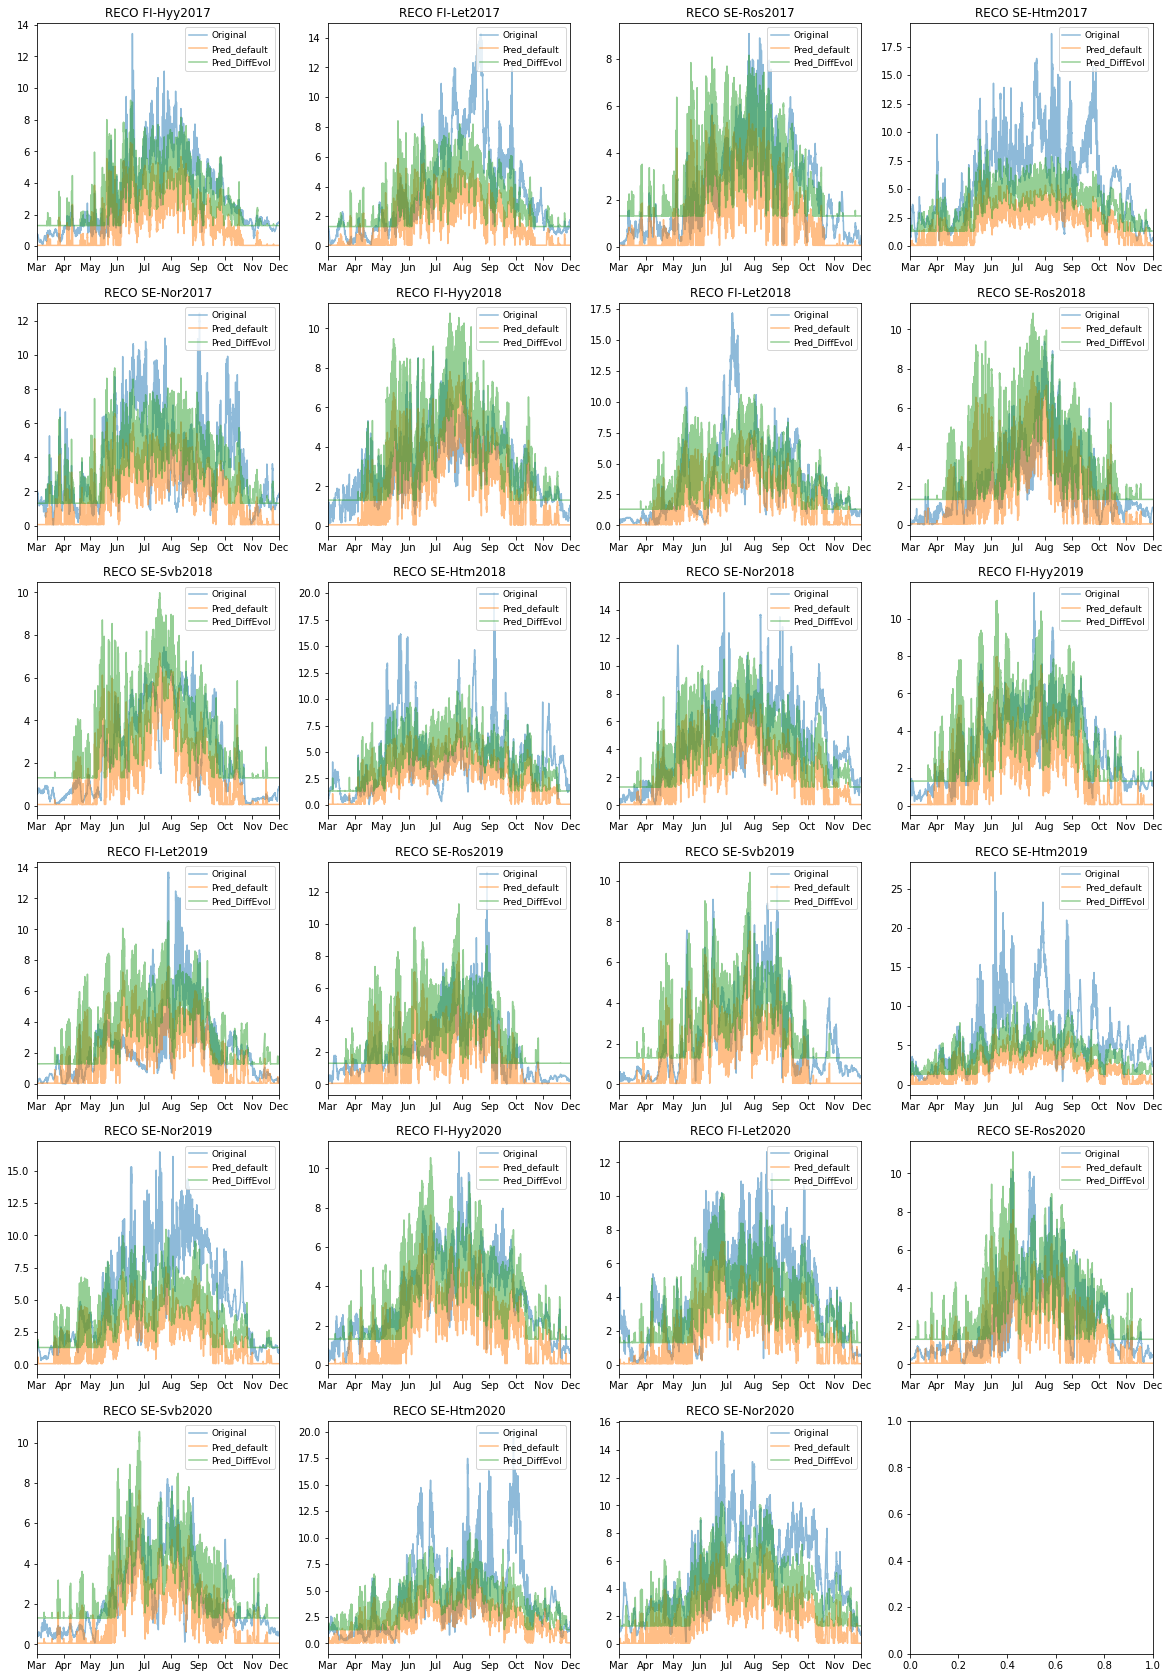

In [12]:
print(len(station_names))
fig, ax = plt.subplots(6, 4, figsize = (20,30))
for i, sitename in enumerate(station_names):
    x = range(0, hh)
    x1 = i* hh
    x2 = x1+ hh
    ax[int(i/4), i%4].plot(x,plot_df['RECO_DT_VUT_REF'][x1:x2], label = 'Original', alpha = 0.5)
    ax[int(i/4), i%4].plot(x,plot_df['RECO_default'][x1:x2], label = 'Pred_default', alpha = 0.5)
    ax[int(i/4), i%4].plot(x,plot_df['RECO_Diffev'][x1:x2], label = 'Pred_DiffEvol', alpha = 0.5)
    
    ax[int(i/4), i%4].set_xlim(0, hh)
    major_ticks = np.arange(0, hh, 1466.6)
    ax[int(i/4), i%4].xaxis.set_ticks(major_ticks)
    ax[int(i/4), i%4].set_xticklabels(['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'])
    
    ax[int(i/4), i%4].set_title(f'RECO {sitename}')
    ax[int(i/4), i%4].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)

#### 2.2. Initial parameters from morris analysis 

In [22]:
#get morris params 
m_alpha = row_contents['alpha'][0]
m_beta = row_contents['beta'][0]
print(m_alpha, m_beta)

0.3 0.24


In [23]:
a, b = lin_reg_grad_dec(m_alpha,m_beta, temp,df_iveg['RECO_DT_VUT_REF'], epochs = 2000)

In [24]:
print(a)
print(b) 

0.33376125674034884
0.23057378831317882


In [25]:
# diff evolution
resp = df_iveg['RECO_DT_VUT_REF'].tolist()
bounds = [[m_alpha- 0.5, m_alpha+ 0.5],[m_beta-1.0, m_beta +1.0]]
# perform the differential evolution search
result = differential_evolution(func_reco, bounds, args = (temp,resp,))
# summarize the result
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
print('Solution: %s' % (solution))

Total Evaluations: 246
Solution: [0.34179815 0.12228912]


In [26]:
# perform the least squares error search
x0 = np.array([m_alpha,m_beta])
result = least_squares(func_reco_lm, x0,args = (temp,resp,), method = 'lm')
print('Total Evaluations: %d' % result['nfev'])
solution_1 = result['x']
print('Solution: %s' % (solution_1))

Total Evaluations: 6
Solution: [0.34179736 0.12230078]


In [27]:
#save params 
optimized_parameters_morr = pd.DataFrame([[d_alpha, d_beta, row_contents['alpha'][0], row_contents['beta'][0], a,b, solution[0],solution[1],solution_1[0],solution_1[1]]], columns = [
'alpha_default', 'beta_default', 'alpha_morr', 'beta_morr', 'alpha_graddec', 'beta_graddec', 'alpha_diffev', 'beta_diffev', 'alpha_ls', 'beta_ls'])
print(optimized_parameters_morr)
optimized_parameters_morr.to_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_morrisopt_alldata_nowinter.csv', header = True, index = False)

   alpha_default  beta_default  alpha_morr  beta_morr  alpha_graddec  \
0       0.287732     -1.093167         0.3       0.24       0.333761   

   beta_graddec  alpha_diffev  beta_diffev  alpha_ls   beta_ls  
0      0.230574      0.341798     0.122289  0.341797  0.122301  


In [13]:
optimized_parameters_morr = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_morrisopt_alldata_nowinter.csv')
optimized_parameters_morr

,alpha_default,beta_default,alpha_morr,beta_morr,alpha_graddec,beta_graddec,alpha_diffev,beta_diffev,alpha_ls,beta_ls
0,0.287732,-1.093167,0.3,0.24,0.333761,0.230574,0.341798,0.122289,0.341797,0.122301


In [14]:
# calculate new rmse of different methods to original reco 
pred_default = reco(optimized_parameters_morr.alpha_default[0],optimized_parameters_morr.beta_default[0],temp)
rmse_default = m_rmse(df_iveg['RECO_DT_VUT_REF'], pred_default)

pred_morr = reco(row_contents['alpha'][0], row_contents['beta'][0], temp)
rmse_morr = m_rmse(df_iveg['RECO_DT_VUT_REF'], pred_morr)

pred_update = reco(optimized_parameters_morr.alpha_graddec[0],optimized_parameters_morr.beta_graddec[0],temp)
rmse_update = m_rmse(df_iveg['RECO_DT_VUT_REF'], pred_update)

pred_diffev = reco(optimized_parameters_morr.alpha_diffev[0], optimized_parameters_morr.beta_diffev[0],temp)
rmse_diffev = m_rmse(df_iveg['RECO_DT_VUT_REF'], pred_diffev)

pred_ls = reco(optimized_parameters_morr.alpha_ls[0],optimized_parameters_morr.beta_ls[0],temp)
rmse_ls = m_rmse(df_iveg['RECO_DT_VUT_REF'], pred_ls)

print(rmse_default, rmse_morr, rmse_update, rmse_diffev, rmse_ls)

2.7519669939080194 2.1314341429424917 2.0964692801307394 2.095738241105088 2.095738241096425


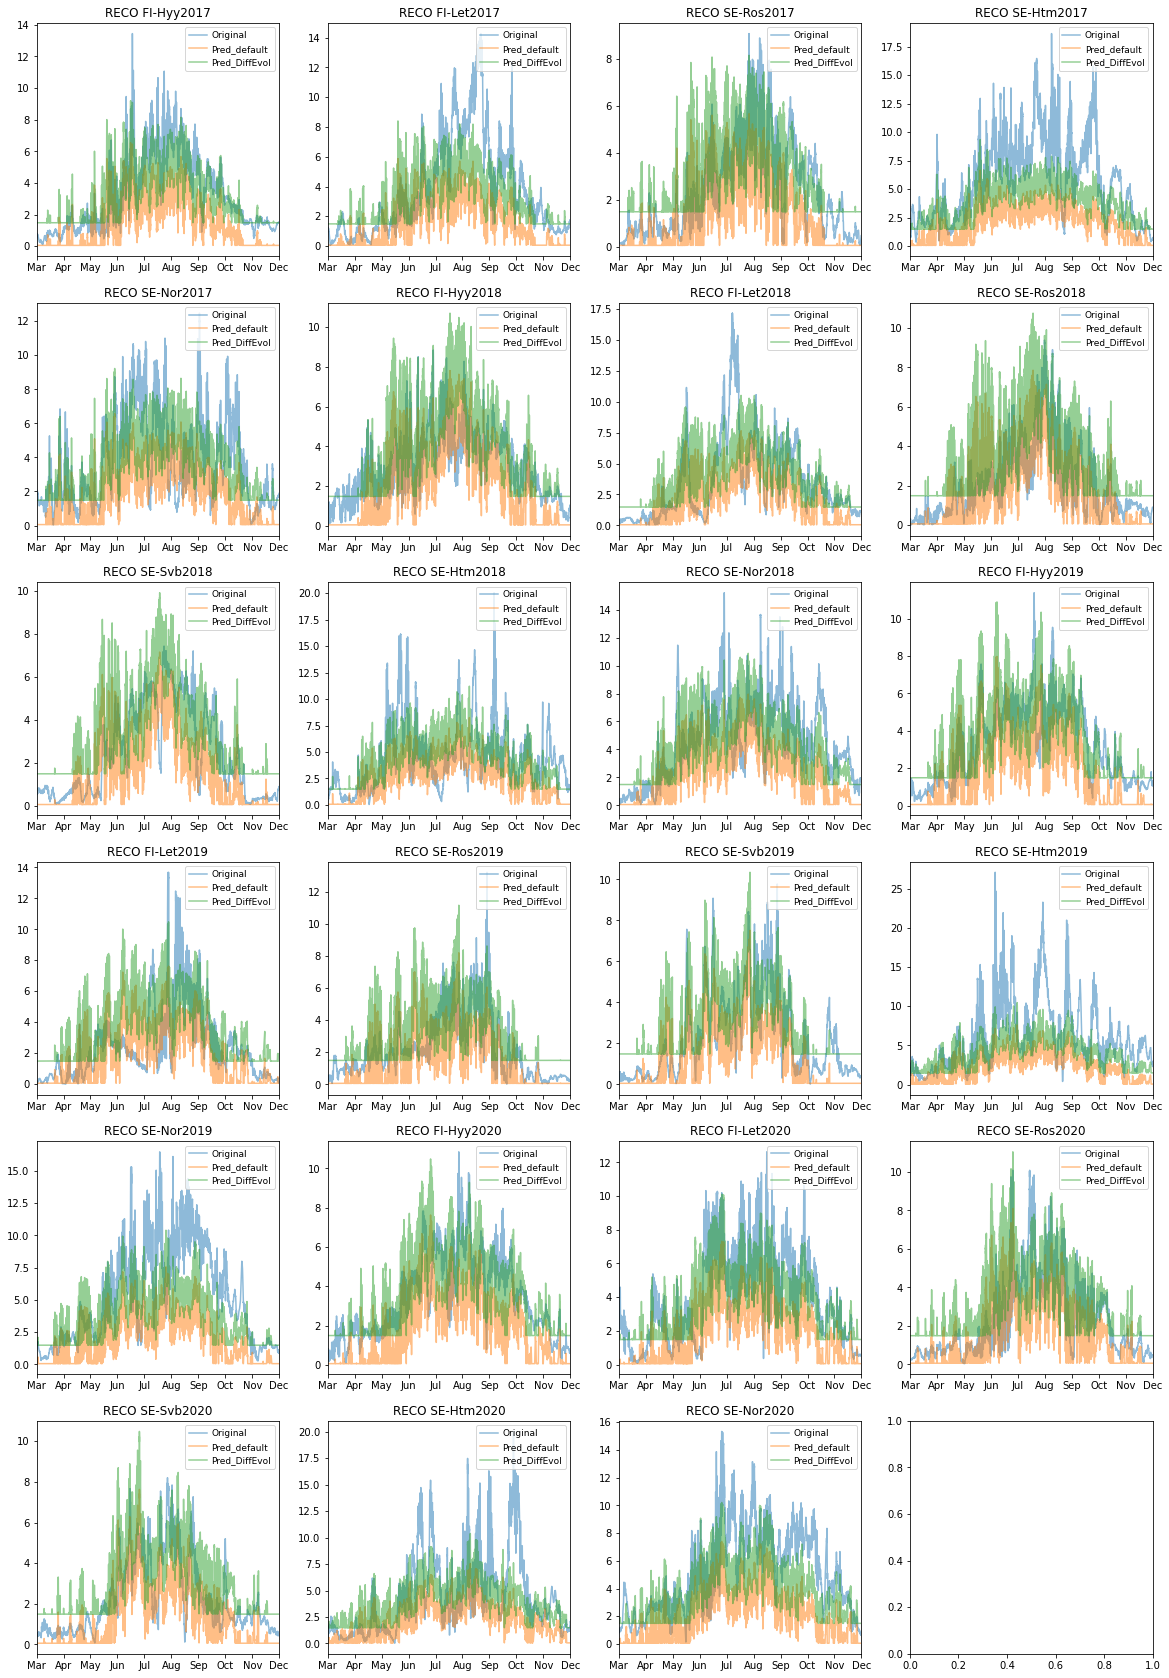

In [15]:
#plot new
pred_default.name = 'RECO_default'
pred_diffev.name = 'RECO_Diffev'
plot_df = pd.concat([pred_default, df_iveg['RECO_DT_VUT_REF'], pred_diffev], axis = 1) 

fig, ax = plt.subplots(6, 4, figsize = (20,30))
for i, sitename in enumerate(station_names):
    x = range(0, hh)
    x1 = i* hh
    x2 = x1+ hh
    ax[int(i/4), i%4].plot(x,plot_df['RECO_DT_VUT_REF'][x1:x2], label = 'Original', alpha = 0.5)
    ax[int(i/4), i%4].plot(x,plot_df['RECO_default'][x1:x2], label = 'Pred_default', alpha = 0.5)
    ax[int(i/4), i%4].plot(x,plot_df['RECO_Diffev'][x1:x2], label = 'Pred_DiffEvol', alpha = 0.5)
    
    ax[int(i/4), i%4].set_xlim(0, hh)
    major_ticks = np.arange(0, hh, 1466.6)
    ax[int(i/4), i%4].xaxis.set_ticks(major_ticks)
    ax[int(i/4), i%4].set_xticklabels(['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'])
    
    ax[int(i/4), i%4].set_title(f'RECO {sitename}')
    ax[int(i/4), i%4].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)

### 3. GEE 
#### 3.1. Init parameters default

In [26]:
#default parameter lambdaGPP, radZero 
d_radZero = default_params[1][0]
d_lambdaGPP = default_params[1][1]

In [2]:
gee = df_iveg['GPP_DT_VUT_REF']
gee[gee < 0] = 0
gee = gee*(-1)
# print(gee)
TMIN = default_params[iveg+1][4]
TMAX = default_params[iveg+1][5]
TOPT = default_params[iveg+1][6]
Temp = temp
EVI = df_iveg['EVI']
LSWI = df_iveg['LSWI']
Rad = df_iveg['RAD']
EVImax = df_iveg['EVImax']
EVImin = df_iveg['EVImin']
LSWImax = df_iveg['LSWImax']
LSWImin = df_iveg['LSWImin']

Tscale = ((Temp - TMIN)*(Temp-TMAX))/(((Temp-TMIN)*(Temp-TMAX))-((Temp-TOPT)*(Temp-TOPT)))
Tscale[Tscale < 0] = 0

if iveg in [3, 6]:
    Wscale = (LSWI - LSWImin)/(LSWImax - LSWImin)
else:
    Wscale = (1 + LSWI)/(1 + LSWImax)

Wscale[Wscale < 0] = 0

Pscale = (1 + LSWI)/2
if iveg == 0:
    Pscale[:] = 1
    
if iveg in [1, 2, 3, 5, 7, 8]:
    threshmark = 0.55
    evithresh = EVImin + (threshmark*(EVImax-EVImin))
    phenologyselect = np.where(EVI> evithresh)
    Pscale[phenologyselect[0]] = 1
#by default, grasslands and savannas never have pScale=1 
Pscale[Pscale < 0] = 0

In [28]:
# optimize params with diff evolution
a = [d_lambdaGPP-0.1, d_lambdaGPP+0.1]
b = [d_radZero-50, d_radZero+50]
bounds = [a,b]
result = differential_evolution(func_gee, bounds,args = (Tscale, Wscale, Pscale, EVI, Rad, gee,))
solution = result['x']

In [29]:
print('Solution diff ev: %s' % (solution))

Solution diff ev: [  0.32577703 225.4595    ]


In [30]:
# optimize params with gd     
lambdaGPP_gd, radZero_gd = gpp_grad_dec(d_lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, d_radZero, gee, L = 0.0001, epochs = 2000)

In [31]:
print('Solution gd 1: ',(lambdaGPP_gd, radZero_gd))

Solution gd 1:  (0.2874536705865461, 275.4593091738578)


In [32]:
# optimize params with gd version 2
bounds_1 = [(d_lambdaGPP-0.1, d_lambdaGPP+0.1),(d_radZero-50, d_radZero+50)]

x0 = np.array([d_lambdaGPP, d_radZero])
result_min = minimize(func_gee, x0, args = (Tscale, Wscale, Pscale, EVI, Rad, gee,), bounds = bounds_1, method = 'Powell')# options={maxiter:100})
solution_min = result_min['x']
print('Solution gd 2: %s' % (solution_min))

Solution gd 2: [  0.32577703 226.93210353]


In [33]:
#optimize params with least squares 
# bounds_2 = ([d_lambdaGPP-0.1,d_radZero-50],[ d_lambdaGPP+0.1,d_radZero+50])
x0 = np.array([d_lambdaGPP, d_radZero])
result_ls = least_squares(func_gee_lm, x0, args = (Tscale, Wscale, Pscale, EVI, Rad, gee,))
solution_ls = result_ls['x']    
print('Solution least squares: %s' % (solution_ls))

Solution least squares: [  0.37964182 178.86669874]


In [34]:
#save params 
optimized_parameters_lr = pd.DataFrame([[d_lambdaGPP, d_radZero, row_contents['lambdaGPP'][0], row_contents['radZero'][0],lambdaGPP_gd, radZero_gd, solution_min[0],solution_min[1], solution[0],solution[1],solution_ls[0],solution_ls[1]]], columns = [
'lambdaGPP_default', 'radZero_default', 'lambdaGPP_morr', 'radZero_morr', 'lambdaGPP_graddec', 'radZero_graddec','lambdaGPP_graddec_1', 'radZero_graddec_1', 'lambdaGPP_diffev', 'radZero_diffev', 'lambdaGPP_ls', 'radZero_ls'])
print(optimized_parameters_lr)
optimized_parameters_lr.to_csv('Oslo_analysis/VPRMoutput/Best_fit_lambdaGPP_radZero_alldata_nowinter.csv', header = True, index = False)

   lambdaGPP_default  radZero_default  lambdaGPP_morr  radZero_morr  \
0           0.225777         275.4595            0.33         230.0   

   lambdaGPP_graddec  radZero_graddec  lambdaGPP_graddec_1  radZero_graddec_1  \
0           0.287454       275.459309             0.325777         226.932104   

   lambdaGPP_diffev  radZero_diffev  lambdaGPP_ls  radZero_ls  
0          0.325777        225.4595      0.379642  178.866699  


In [35]:
optimized_parameters_lr = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_lambdaGPP_radZero_alldata_nowinter.csv')

In [36]:
#calculate new rmse of different methods to original gpp

pred_default = GEE_calculate(optimized_parameters_lr.lambdaGPP_default[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr.radZero_default[0])
# pred_default = optimized_parameters_lr.lambdaGPP_default[0]*Tscale*Wscale*Pscale*EVI*Rad/(1 + (Rad/optimized_parameters_lr.radZero_default[0]))*(-1)
# rmse_default = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_default)
rmse_default = m_rmse(gee, pred_default)


pred_morr = GEE_calculate(row_contents['lambdaGPP'][0],Tscale, Wscale, Pscale, EVI, Rad, row_contents['radZero'][0])
# pred_morr = row_contents['lambdaGPP'][0]*Tscale*Wscale*Pscale*EVI*Rad/(1 + (Rad/row_contents['radZero'][0]))*(-1)
# rmse_morr = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_morr)
rmse_morr = m_rmse(gee, pred_morr)


# pred_update = optimized_parameters_lr.lambdaGPP_graddec[0]*Tscale*Wscale*Pscale*EVI*Rad/(1 + (Rad/optimized_parameters_lr.radZero_graddec[0]))*(-1)
pred_update = GEE_calculate(optimized_parameters_lr.lambdaGPP_graddec[0], Tscale, Wscale, Pscale, EVI, Rad, optimized_parameters_lr.radZero_graddec[0])
# rmse_update = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_update)
rmse_update = m_rmse(gee, pred_update)


pred_update_1 = GEE_calculate(optimized_parameters_lr.lambdaGPP_graddec_1[0], Tscale, Wscale, Pscale, EVI, Rad, optimized_parameters_lr.radZero_graddec_1[0])
# rmse_update_1 = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_update_1)
rmse_update_1 = m_rmse(gee, pred_update_1)

pred_diffev = GEE_calculate(optimized_parameters_lr.lambdaGPP_diffev[0], Tscale, Wscale, Pscale, EVI, Rad, optimized_parameters_lr.radZero_diffev[0])
# rmse_diffev = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_diffev)
rmse_diffev = m_rmse(gee, pred_diffev)


pred_ls = GEE_calculate(optimized_parameters_lr.lambdaGPP_ls[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr.radZero_diffev[0])
# rmse_ls = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_ls)
rmse_ls = m_rmse(gee, pred_ls)


print(rmse_default, rmse_morr, rmse_update, rmse_update_1, rmse_diffev, rmse_ls)

3.308967787852382 2.997501068949898 3.0078887769342444 2.9921923088119105 2.9917013116232876 3.174860287862278


In [37]:
#plot 
pred_default.name = 'GPP_default'
pred_diffev.name = 'GPP_Diffev'
plot_df = pd.concat([pred_default, gee, pred_diffev], axis = 1) 

23


KeyError: 'GPP_Diffev'

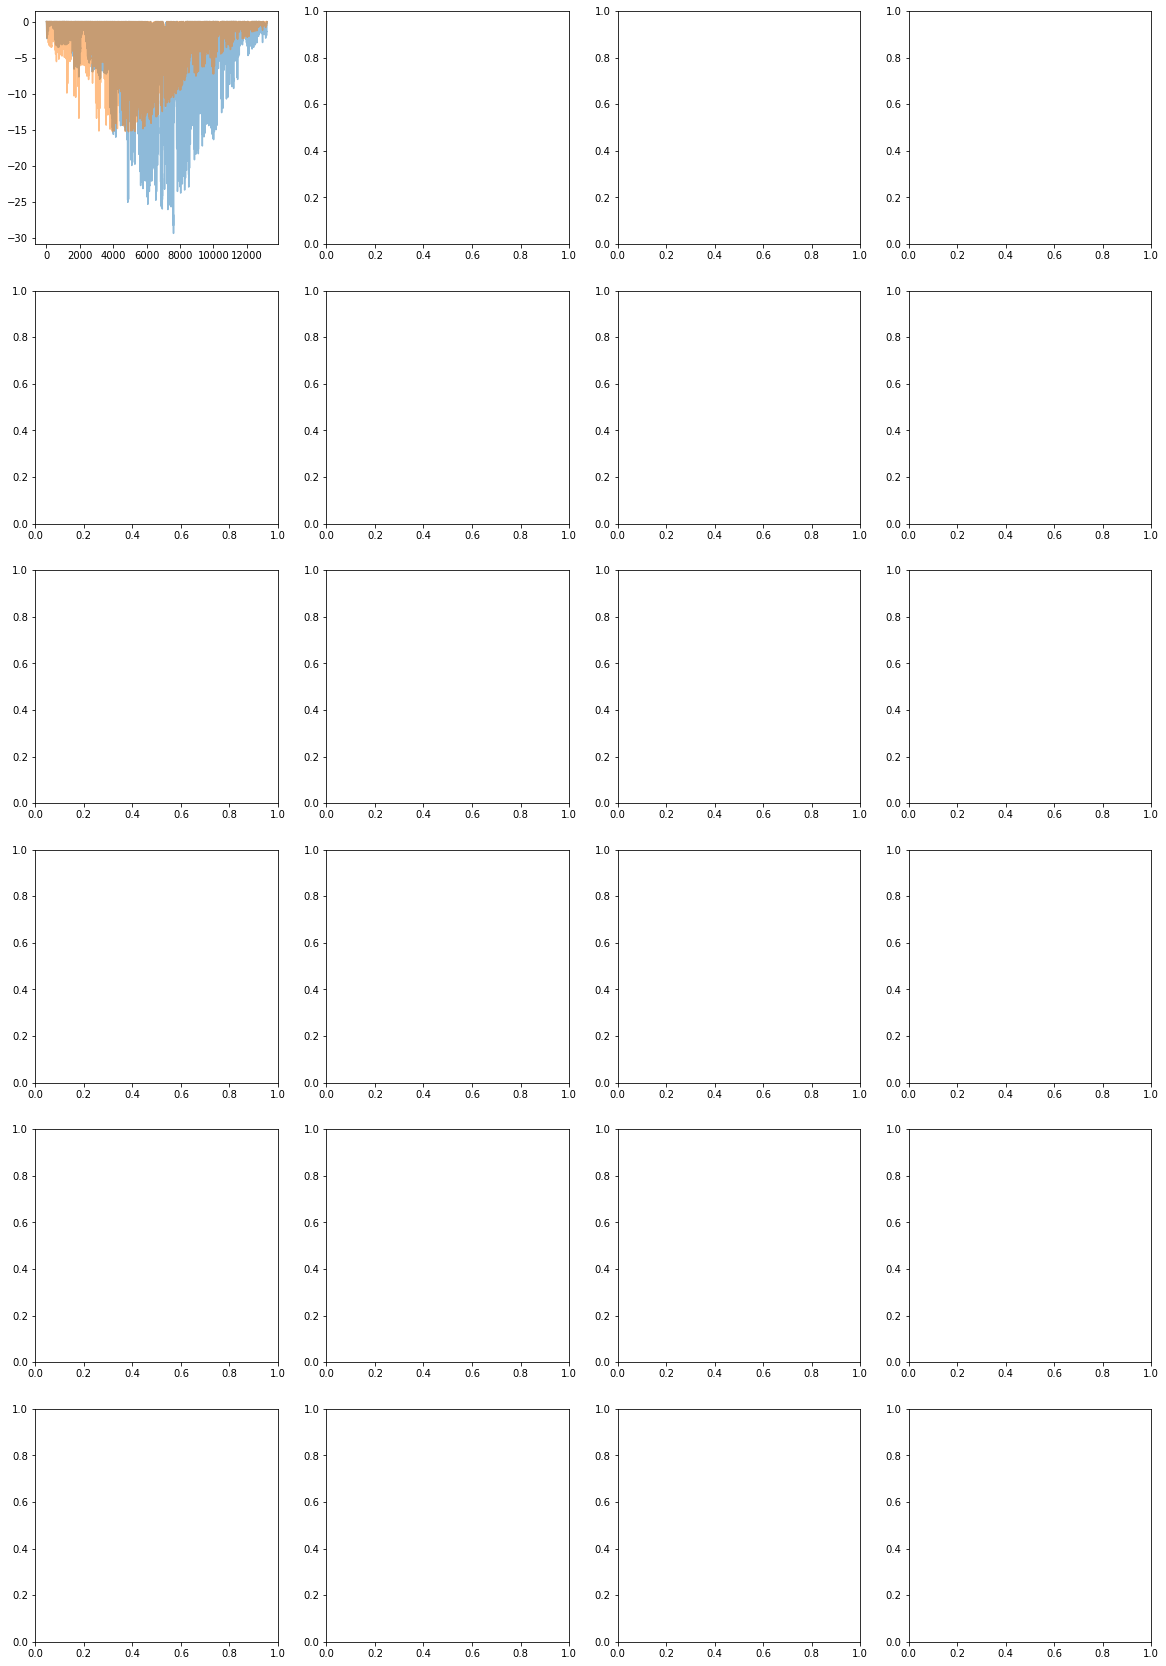

In [51]:
hh = ((31+ 30+31+ 30+31+31+30+31+30)*48)
print(len(station_names))
fig, ax = plt.subplots(6, 4, figsize = (20,30))
for i, sitename in enumerate(station_names):
    x = range(0, hh)
    x1 = i* hh
    x2 = x1+ hh
    ax[int(i/4), i%4].plot(x,plot_df['GPP_DT_VUT_REF'][x1:x2], label = 'Original', alpha = 0.5)
    ax[int(i/4), i%4].plot(x,plot_df['GPP_default'][x1:x2], label = 'Pred_default', alpha = 0.5)
    ax[int(i/4), i%4].plot(x,plot_df['GPP_Diffev'][x1:x2], label = 'Pred_DiffEvol', alpha = 0.5)
    
    ax[int(i/4), i%4].set_xlim(0, hh)
    major_ticks = np.arange(0, hh, 1466.6)
    ax[int(i/4), i%4].xaxis.set_ticks(major_ticks)
    ax[int(i/4), i%4].set_xticklabels(['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'])
    
    ax[int(i/4), i%4].set_title(f'GPP {sitename}')
    ax[int(i/4), i%4].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)

#### 3.1 Init parameters from morris analysis

In [24]:
#get morris params 
m_lambdaGPP = row_contents['lambdaGPP'][0]
m_radZero = row_contents['radZero'][0]

In [25]:
print(m_lambdaGPP, m_radZero)

0.33 230.0


In [41]:
# optimize with grad dec 
l, r = gpp_grad_dec(m_lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, m_radZero, gee, L = 0.0001, epochs = 2000)

In [42]:
print(l,r) 

0.3216949546649842 229.99983051379584


In [43]:
# optimize params with gd version 2

bounds_1 = [(m_lambdaGPP-0.1, m_lambdaGPP+0.1),(m_radZero-25, m_radZero+25)]

x0 = np.array([m_lambdaGPP, m_radZero])
result_min = minimize(func_gee, x0, args = (Tscale, Wscale, Pscale, EVI, Rad, gee,), bounds = bounds_1, method = 'Powell')# options={maxiter:100})
solution_min_m = result_min['x']
print('Solution: %s' % (solution_min_m))

Solution: [  0.34526611 205.00000001]


In [44]:
# optimize params with diff evolution
a = [m_lambdaGPP-0.1, m_lambdaGPP+0.1]
b = [m_radZero-25, m_radZero+25]
bounds = [a,b]
result = differential_evolution(func_gee, bounds, args = (Tscale, Wscale, Pscale, EVI, Rad, gee,))
solution_m_de = result['x']

In [45]:
print(solution_m_de) 

[  0.34660537 205.        ]


In [46]:
#optimize params with least squares 
# bounds_2 = ([m_lambdaGPP-0.1,m_radZero-25],[ m_lambdaGPP+0.1,m_radZero+25])

result_ls = least_squares(func_gee_lm, x0, args = (Tscale, Wscale, Pscale, EVI, Rad, gee,), method = 'lm')
solution_ls_m = result_ls['x']    
print('Solution: %s' % (solution_ls_m))

Solution: [  0.37964146 178.86694873]


In [47]:
#save params

optimized_parameters_lr_m = pd.DataFrame([[d_lambdaGPP, d_radZero, row_contents['lambdaGPP'][0], row_contents['radZero'][0],l,r,solution_min_m[0],solution_min_m[1], solution_m_de[0],solution_m_de[1], solution_ls_m[0], solution_ls_m[1]]], columns = [
'lambdaGPP_default', 'radZero_default', 'lambdaGPP_morr', 'radZero_morr', 'lambdaGPP_graddec', 'radZero_graddec','lambdaGPP_graddec_1', 'radZero_graddec_1', 'lambdaGPP_diffev', 'radZero_diffev', 'lambdaGPP_ls', 'radZero_ls'])
print(optimized_parameters_lr_m)
optimized_parameters_lr_m.to_csv('Oslo_analysis/VPRMoutput/Best_fit_lambdaGPP_radZero_morrisopt_alldata_nowinter.csv', header = True, index = False)


   lambdaGPP_default  radZero_default  lambdaGPP_morr  radZero_morr  \
0           0.225777         275.4595            0.33         230.0   

   lambdaGPP_graddec  radZero_graddec  lambdaGPP_graddec_1  radZero_graddec_1  \
0           0.321695       229.999831             0.345266              205.0   

   lambdaGPP_diffev  radZero_diffev  lambdaGPP_ls  radZero_ls  
0          0.346605           205.0      0.379641  178.866949  


In [48]:
optimized_parameters_lr_m = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_lambdaGPP_radZero_morrisopt_alldata_nowinter.csv')

In [49]:
#calculate error 
# calculate rmse of different methods to original gpp

pred_default = GEE_calculate(optimized_parameters_lr_m.lambdaGPP_default[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr_m.radZero_default[0])
# pred_default = optimized_parameters_lr.lambdaGPP_default[0]*Tscale*Wscale*Pscale*EVI*Rad/(1 + (Rad/optimized_parameters_lr.radZero_default[0]))*(-1)
rmse_default = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_default)

pred_morr = GEE_calculate(row_contents['lambdaGPP'][0],Tscale, Wscale, Pscale, EVI, Rad, row_contents['radZero'][0])
# pred_morr = row_contents['lambdaGPP'][0]*Tscale*Wscale*Pscale*EVI*Rad/(1 + (Rad/row_contents['radZero'][0]))*(-1)
rmse_morr = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_morr)

pred_update = GEE_calculate(optimized_parameters_lr_m.lambdaGPP_graddec[0], Tscale, Wscale, Pscale, EVI, Rad, optimized_parameters_lr_m.radZero_graddec[0])
# rmse_update = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_update)
rmse_update = m_rmse(gee, pred_update)

pred_update_1 = GEE_calculate(optimized_parameters_lr_m.lambdaGPP_graddec_1[0], Tscale, Wscale, Pscale, EVI, Rad, optimized_parameters_lr_m.radZero_graddec_1[0])
rmse_update_1 = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_update_1)

pred_diffev = GEE_calculate(optimized_parameters_lr_m.lambdaGPP_diffev[0], Tscale, Wscale, Pscale, EVI, Rad, optimized_parameters_lr_m.radZero_diffev[0])
rmse_diffev = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_diffev)

pred_ls = GEE_calculate(optimized_parameters_lr_m.lambdaGPP_ls[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr_m.radZero_diffev[0])
rmse_ls = m_rmse(df_iveg['GPP_DT_VUT_REF']*(-1), pred_ls)

print(rmse_default, rmse_morr, rmse_update, rmse_update_1, rmse_diffev, rmse_ls)


3.308967787852382 2.997501068949898 2.99289445010507 2.987437790426405 2.9873342540490784 3.0496869484147626


In [ ]:
#plot 
pred_default.name = 'GPP_default'
pred_diffev.name = 'GPP_morr_Diffev'
plot_df = pd.concat([pred_default, gee, pred_diffev], axis = 1) 
fig, ax = plt.subplots(6, 4, figsize = (20,30))
for i, sitename in enumerate(station_names):
    x = range(0, hh)
    x1 = i* hh
    x2 = x1+ hh
    ax[int(i/4), i%4].plot(x,plot_df['GPP_DT_VUT_REF'][x1:x2], label = 'Original', alpha = 0.5)
    ax[int(i/4), i%4].plot(x,plot_df['GPP_default'][x1:x2], label = 'Pred_default', alpha = 0.5)
    ax[int(i/4), i%4].plot(x,plot_df['GPP_morr_Diffev'][x1:x2], label = 'Pred_DiffEvol', alpha = 0.5)
    
    ax[int(i/4), i%4].set_xlim(0, hh)
    major_ticks = np.arange(0, hh, 1466.6)
    ax[int(i/4), i%4].xaxis.set_ticks(major_ticks)
    ax[int(i/4), i%4].set_xticklabels(['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'])
    
    ax[int(i/4), i%4].set_title(f'GPP {sitename}')
    ax[int(i/4), i%4].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)


### Reco and GPP

In [4]:
optimized_parameters = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_alldata_nowinter.csv')
optimized_parameters_lr = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_lambdaGPP_radZero_alldata_nowinter.csv')

reco_default = reco(optimized_parameters.alpha_default[0],optimized_parameters.beta_default[0],temp)
gpp_default = GEE_calculate(optimized_parameters_lr.lambdaGPP_default[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr.radZero_default[0])
nee_default = (gpp_default + reco_default)
rmse_default = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_default)


reco_morr = reco(row_contents['alpha'][0], row_contents['beta'][0], temp)
gpp_morr = GEE_calculate(row_contents['lambdaGPP'][0],Tscale, Wscale, Pscale, EVI, Rad, row_contents['radZero'][0])
nee_morr = (gpp_morr + reco_morr)
rmse_morr = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_morr)


reco_graddec = reco(optimized_parameters.alpha_graddec[0],optimized_parameters.beta_graddec[0],temp)
gpp_graddec = GEE_calculate(optimized_parameters_lr.lambdaGPP_graddec[0], Tscale, Wscale, Pscale, EVI, Rad, optimized_parameters_lr.radZero_graddec[0])
nee_graddec = (gpp_graddec + reco_graddec)
rmse_graddec = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_graddec)


reco_diffev = reco(optimized_parameters.alpha_diffev[0], optimized_parameters.beta_diffev[0],temp)
gpp_diffev = GEE_calculate(optimized_parameters_lr.lambdaGPP_diffev[0], Tscale, Wscale, Pscale, EVI, Rad, optimized_parameters_lr.radZero_diffev[0])
nee_diffev = (gpp_diffev + reco_diffev)
rmse_diffev = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_diffev)


reco_ls = reco(optimized_parameters.alpha_ls[0],optimized_parameters.beta_ls[0],temp)
gpp_ls = GEE_calculate(optimized_parameters_lr.lambdaGPP_ls[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr.radZero_diffev[0])
nee_ls = (gpp_ls + reco_ls)
rmse_ls = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_ls)

print(rmse_default, rmse_morr, rmse_graddec, rmse_diffev, rmse_ls)
# pred_update_1 = GEE_calculate(optimized_parameters_lr.lambdaGPP_graddec_1[0], Tscale, Wscale, Pscale, EVI, Rad, optimized_parameters_lr.radZero_graddec_1[0])
# rmse_update_1 = m_rmse(gee, pred_update_1)

3.7047699912999983 3.3675639788094434 3.4160479806098167 3.36898502930194 3.4092935413900665


In [40]:
optimized_parameters_lr_m

,lambdaGPP_default,radZero_default,lambdaGPP_morr,radZero_morr,lambdaGPP_graddec,radZero_graddec,lambdaGPP_graddec_1,radZero_graddec_1,lambdaGPP_diffev,radZero_diffev,lambdaGPP_ls,radZero_ls
0,0.225777,275.4595,0.4,230.0,0.320133,229.999764,0.34365,205.0,0.344911,205.0,0.37591,180.177642


In [5]:
optimized_parameters_morr = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_morrisopt_alldata_nowinter.csv')
optimized_parameters_lr_m = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_lambdaGPP_radZero_morrisopt_alldata_nowinter.csv')

reco_default = reco(optimized_parameters_morr.alpha_default[0],optimized_parameters_morr.beta_default[0],temp)
gee_default = GEE_calculate(optimized_parameters_lr_m.lambdaGPP_default[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr_m.radZero_default[0])
nee_default = (gee_default + reco_default)
rmse_default = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_default)

reco_morr = reco(row_contents['alpha'][0], row_contents['beta'][0], temp)
gpp_morr = GEE_calculate(row_contents['lambdaGPP'][0],Tscale, Wscale, Pscale, EVI, Rad, row_contents['radZero'][0])
nee_morr = (gpp_morr + reco_morr)
rmse_morr = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_morr)

reco_graddec = reco(optimized_parameters_morr.alpha_graddec[0],optimized_parameters_morr.beta_graddec[0],temp)
gee_graddec = GEE_calculate(optimized_parameters_lr_m.lambdaGPP_graddec[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr_m.radZero_graddec[0])
nee_graddec = (gee_graddec + reco_graddec)
rmse_graddec = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_graddec)

reco_diffev = reco(optimized_parameters_morr.alpha_diffev[0],optimized_parameters_morr.beta_diffev[0],temp)
gee_diffev = GEE_calculate(optimized_parameters_lr_m.lambdaGPP_diffev[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr_m.radZero_diffev[0])
nee_diffev = (gee_diffev + reco_diffev)
rmse_diffev = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_diffev)

reco_ls = reco(optimized_parameters_morr.alpha_ls[0],optimized_parameters_morr.beta_ls[0],temp)
gee_ls = GEE_calculate(optimized_parameters_lr_m.lambdaGPP_ls[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr_m.radZero_ls[0])
nee_ls = (gee_ls + reco_ls)
rmse_ls = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_ls)

print(rmse_default, rmse_morr, rmse_graddec, rmse_diffev, rmse_ls)


3.7047699912999983 3.3675639788094434 3.3696303650774975 3.370096663239962 3.375556017654485


### 4. Nee complete
#### 4.1 Init parameter default

In [4]:
#params default 
iveg = 0
d_lambdaGPP = default_params[iveg+1][1]
d_radZero = default_params[iveg+1][0]
#default parameter alpha beta 
d_alpha = default_params[iveg+1][2]
d_beta = default_params[iveg+1][3]
nee = df_iveg['NEE_VUT_REF']

TMIN = default_params[iveg+1][4]
TMAX = default_params[iveg+1][5]
TOPT = default_params[iveg+1][6]
Temp = temp
EVI = df_iveg['EVI']
LSWI = df_iveg['LSWI']
Rad = df_iveg['RAD']
EVImax = df_iveg['EVImax']
EVImin = df_iveg['EVImin']
LSWImax = df_iveg['LSWImax']
LSWImin = df_iveg['LSWImin']

Tscale = ((Temp - TMIN)*(Temp-TMAX))/(((Temp-TMIN)*(Temp-TMAX))-((Temp-TOPT)*(Temp-TOPT)))
Tscale[Tscale < 0] = 0

if iveg in [3, 6]:
    Wscale = (LSWI - LSWImin)/(LSWImax - LSWImin)
else:
    Wscale = (1 + LSWI)/(1 + LSWImax)

Wscale[Wscale < 0] = 0

Pscale = (1 + LSWI)/2
if iveg == 0:
    Pscale[:] = 1
    
if iveg in [1, 2, 3, 5, 7, 8]:
    threshmark = 0.55
    evithresh = EVImin + (threshmark*(EVImax-EVImin))
    phenologyselect = np.where(EVI> evithresh)
    Pscale[phenologyselect[0]] = 1
#by default, grasslands and savannas never have pScale=1 
Pscale[Pscale < 0] = 0


x0 = np.array([d_alpha,d_beta, d_lambdaGPP, d_radZero])

In [47]:
# least squares 
result_ls_nee = least_squares(func_nee_lm, x0, args = (temp,Tscale, Wscale, Pscale, EVI, Rad, nee,), method = 'lm')
solution_ls_nee = result_ls_nee['x']    
print('Solution: %s' % (solution_ls_nee))

Solution: [ 4.01238826e-01 -5.68425654e-02  3.96357034e-01  2.03423370e+02]


In [40]:
# optimize params with diff evolution
al = [0, d_alpha+ 0.5]
bet = [d_beta-1.0, d_beta +1.0]
lam = [d_lambdaGPP-0.1, d_lambdaGPP+0.1]
rad = [d_radZero-25, d_radZero+25]

bounds = [al,bet, lam, rad ]
result = differential_evolution(func_nee, bounds, args = (temp,Tscale, Wscale, Pscale, EVI, Rad, nee,))
solution_de_nee = result['x']


In [41]:
print(solution_de_nee)

[ 3.84047676e-01 -9.31669600e-02  3.25777030e-01  2.63844442e+02]


In [43]:
optimized_parameters_nee = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_lambdaGPP_radZero_alldata_nowinter.csv')
optimized_parameters_nee.alpha_diffev = solution_de_nee[0]
optimized_parameters_nee.beta_diffev = solution_de_nee[1]
optimized_parameters_nee.lambdaGPP_diffev = solution_de_nee[2]
optimized_parameters_nee.radZero_diffev = solution_de_nee[3]
optimized_parameters_nee.to_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_lambdaGPP_radZero_alldata_nowinter.csv', header = True, index = False)

In [50]:
# grad_dec
al, bet,lam, radZ = nee_grad_dec(d_alpha, d_beta, d_lambdaGPP, d_radZero, temp,Tscale, Wscale, Pscale, EVI, Rad, nee, epochs = 2000)
print(al, bet,lam, radZ)

0.4721586772663604 -1.0418577234534105 0.329455747494912 275.3947516163868


In [ ]:
#save params
optimized_parameters_nee = pd.DataFrame([[d_alpha, d_beta, d_lambdaGPP, d_radZero, row_contents['alpha'][0], row_contents['beta'][0], row_contents['lambdaGPP'][0], row_contents['radZero'][0],al, bet,lam, radZ, solution_de_nee[0],solution_de_nee[1], solution_de_nee[2], solution_de_nee[3], solution_ls_nee[0],solution_ls_nee[1], solution_ls_nee[2], solution_ls_nee[3]]], 
                                        columns = ['alpha_default', 'beta_default','lambdaGPP_default', 'radZero_default', 'alpha_morr','beta_morr','lambdaGPP_morr', 'radZero_morr', 'alpha_graddec', 'beta_graddec', 'lambdaGPP_graddec', 'radZero_graddec','alpha_diffev', 'beta_diffev', 'lambdaGPP_diffev', 'radZero_diffev','alpha_ls','beta_ls', 'lambdaGPP_ls', 'radZero_ls'])
print(optimized_parameters_nee)
optimized_parameters_nee.to_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_lambdaGPP_radZero_alldata_nowinter.csv', header = True, index = False)

In [44]:
#calculate rmse 
optimized_parameters_nee = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_lambdaGPP_radZero_alldata_nowinter.csv')

# print(optimized_parameters_nee)

reco_default = reco(optimized_parameters_nee.alpha_default[0],optimized_parameters_nee.beta_default[0],temp)
gee_default = GEE_calculate(optimized_parameters_nee.lambdaGPP_default[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_nee.radZero_default[0])
nee_default = (gee_default + reco_default)
# print(nee_default) 
# print(df_iveg['NEE_VUT_REF'])
rmse_default = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_default)

reco_morr = reco(optimized_parameters_nee.alpha_morr[0],optimized_parameters_nee.beta_morr[0],temp)
gee_morr = GEE_calculate(optimized_parameters_nee.lambdaGPP_morr[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_nee.radZero_morr[0])
nee_morr = (gee_morr + reco_morr)
rmse_morr = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_morr)

reco_graddec = reco(optimized_parameters_nee.alpha_graddec[0],optimized_parameters_nee.beta_graddec[0],temp)
gee_graddec = GEE_calculate(optimized_parameters_nee.lambdaGPP_graddec[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_nee.radZero_graddec[0])
nee_graddec = (gee_graddec + reco_graddec)
rmse_graddec = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_graddec)

reco_diffev = reco(optimized_parameters_nee.alpha_diffev[0],optimized_parameters_nee.beta_diffev[0],temp)
gee_diffev = GEE_calculate(optimized_parameters_nee.lambdaGPP_diffev[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_nee.radZero_diffev[0])
nee_diffev = (gee_diffev + reco_diffev)
rmse_diffev = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_diffev)

reco_ls = reco(optimized_parameters_nee.alpha_ls[0],optimized_parameters_nee.beta_ls[0],temp)
gee_ls = GEE_calculate(optimized_parameters_nee.lambdaGPP_ls[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_nee.radZero_ls[0])
nee_ls = (gee_ls + reco_ls)
rmse_ls = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_ls)

print(rmse_default, rmse_morr, rmse_graddec, rmse_diffev, rmse_ls)
# optimized_parameters_nee

3.7047699912999983 3.3675639788094434 3.366436770907113 3.3328570597485814 3.323061348892949


In [53]:
# plottt

#### 4.2 Init parameters morris analysis

In [22]:
m_lambdaGPP = row_contents['lambdaGPP'][0]
m_radZero = row_contents['radZero'][0]
#default parameter alpha beta 
m_alpha = row_contents['alpha'][0]
m_beta = row_contents['beta'][0]
x0 = np.array([m_alpha,m_beta, m_lambdaGPP, m_radZero])

In [23]:
print(m_lambdaGPP, m_radZero)

0.33 230.0


In [46]:
# least squares 
result_ls_nee = least_squares(func_nee_lm, x0, args = (temp,Tscale, Wscale, Pscale, EVI, Rad, nee,), method = 'lm')
solution_ls_nee_m = result_ls_nee['x']    
print('Solution: %s' % (solution_ls_nee_m))

Solution: [ 4.01239332e-01 -5.68377094e-02  3.96362695e-01  2.03419260e+02]


In [47]:
# optimize params with diff evolution
al = [0, m_alpha+ 0.5]
bet = [m_beta-1.0, m_beta +1.0]
lam = [m_lambdaGPP-0.1, m_lambdaGPP+0.1]
rad = [m_radZero-25, m_radZero+25]

bounds = [al,bet, lam, rad ]
result = differential_evolution(func_nee, bounds, args = (temp,Tscale, Wscale, Pscale, EVI, Rad, nee,))
solution_de_nee_m = result['x']
print(solution_de_nee_m)

[ 3.95552324e-01 -9.82430635e-02  3.46391814e-01  2.47001917e+02]


In [48]:
# grad_dec
al, bet,lam, radZ = nee_grad_dec(m_alpha, m_beta, m_lambdaGPP, m_radZero, temp,Tscale, Wscale, Pscale, EVI, Rad, nee, epochs = 2000)
print(al, bet,lam, radZ)

0.36902401491918063 0.24560746266145322 0.36043664330651115 230.01439383662336


In [49]:
#save params
optimized_parameters_nee_morr = pd.DataFrame([[d_alpha, d_beta, d_lambdaGPP, d_radZero, row_contents['alpha'][0], row_contents['beta'][0], row_contents['lambdaGPP'][0], row_contents['radZero'][0],al, bet,lam, radZ, solution_de_nee_m[0],solution_de_nee_m[1], solution_de_nee_m[2], solution_de_nee_m[3], solution_ls_nee_m[0],solution_ls_nee_m[1], solution_ls_nee_m[2], solution_ls_nee_m[3]]], 
                                        columns = ['alpha_default', 'beta_default','lambdaGPP_default', 'radZero_default', 'alpha_morr','beta_morr','lambdaGPP_morr', 'radZero_morr', 'alpha_graddec', 'beta_graddec', 'lambdaGPP_graddec', 'radZero_graddec','alpha_diffev', 'beta_diffev', 'lambdaGPP_diffev', 'radZero_diffev','alpha_ls','beta_ls', 'lambdaGPP_ls', 'radZero_ls'])
print(optimized_parameters_nee_morr)
optimized_parameters_nee_morr.to_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_lambdaGPP_radZero_morr_alldata_nowinter.csv', header = True, index = False)

   alpha_default  beta_default  lambdaGPP_default  radZero_default  \
0       0.287732     -1.093167           0.225777         275.4595   

   alpha_morr  beta_morr  lambdaGPP_morr  radZero_morr  alpha_graddec  \
0         0.3       0.24            0.33         230.0       0.369024   

   beta_graddec  lambdaGPP_graddec  radZero_graddec  alpha_diffev  \
0      0.245607           0.360437       230.014394      0.395552   

   beta_diffev  lambdaGPP_diffev  radZero_diffev  alpha_ls   beta_ls  \
0    -0.098243          0.346392      247.001917  0.401239 -0.056838   

   lambdaGPP_ls  radZero_ls  
0      0.396363   203.41926  


In [8]:
#calculate rmse 
optimized_parameters_nee_m = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_lambdaGPP_radZero_morr_alldata_nowinter.csv')

reco_default = reco(optimized_parameters_nee_m.alpha_default[0],optimized_parameters_nee_m.beta_default[0],temp)
gee_default = GEE_calculate(optimized_parameters_nee_m.lambdaGPP_default[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_nee_m.radZero_default[0])
nee_default = (gee_default + reco_default)
rmse_default = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_default)

reco_morr = reco(optimized_parameters_nee_m.alpha_morr[0],optimized_parameters_nee_m.beta_morr[0],temp)
gee_morr = GEE_calculate(optimized_parameters_nee_m.lambdaGPP_morr[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_nee_m.radZero_morr[0])
nee_morr = (gee_morr + reco_morr)
rmse_morr = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_morr)

reco_graddec = reco(optimized_parameters_nee_m.alpha_graddec[0],optimized_parameters_nee_m.beta_graddec[0],temp)
gee_graddec = GEE_calculate(optimized_parameters_nee_m.lambdaGPP_graddec[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_nee_m.radZero_graddec[0])
nee_graddec = (gee_graddec + reco_graddec)
rmse_graddec = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_graddec)

reco_diffev = reco(optimized_parameters_nee_m.alpha_diffev[0],optimized_parameters_nee_m.beta_diffev[0],temp)
gee_diffev = GEE_calculate(optimized_parameters_nee_m.lambdaGPP_diffev[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_nee_m.radZero_diffev[0])
nee_diffev = (gee_diffev + reco_diffev)
rmse_diffev = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_diffev)

reco_ls = reco(optimized_parameters_nee_m.alpha_ls[0],optimized_parameters_nee_m.beta_ls[0],temp)
gee_ls = GEE_calculate(optimized_parameters_nee_m.lambdaGPP_ls[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_nee_m.radZero_ls[0])
nee_ls = (gee_ls + reco_ls)
rmse_ls = m_rmse(df_iveg['NEE_VUT_REF']/3600, nee_ls)

print(rmse_default, rmse_morr, rmse_graddec, rmse_diffev, rmse_ls)

3.7047699912999983 3.3675639788094434 3.329129675914883 3.328113962651692 3.323061348876506


In [24]:
# df_main_results = pd.concat(df_iveg['NEE_VUT_REF'], nee_default, nee_ls)
# print(df_iveg['NEE_VUT_REF'], nee_default, nee_ls)
df_main_results = pd.DataFrame()
df_main_results = pd.concat([df_iveg['NEE_VUT_REF']/3600, nee_default, nee_ls], axis=1)
# print(df_main_results.columns)
df_main_results = df_main_results.rename({0: "NEE_default", 1: 'NEE_LM'}, axis=1)


In [26]:
df_main_results.to_csv('Oslo_analysis/VPRMoutput/Results_NEE_pred_default_LM.csv', header = True, index=False)

In [ ]:
### plotttt

### 5. Statistical tests

In [3]:
# Diebold marrinaro test 
# calculate residuals 
optimized_parameters = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_alpha_beta_alldata_nowinter.csv')
optimized_parameters_lr = pd.read_csv('Oslo_analysis/VPRMoutput/Best_fit_lambdaGPP_radZero_alldata_nowinter.csv')

reco_default = reco(optimized_parameters.alpha_default[0],optimized_parameters.beta_default[0],temp)
gee_default = GEE_calculate(optimized_parameters_lr.lambdaGPP_default[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr.radZero_default[0])
nee_default = (gee_default + reco_default)
resid_default = df_iveg['NEE_VUT_REF']/3600 - nee_default

reco_morr = reco(optimized_parameters.alpha_morr[0],optimized_parameters.beta_morr[0],temp)
gee_morr = GEE_calculate(optimized_parameters_lr.lambdaGPP_morr[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr.radZero_morr[0])
nee_morr = (gee_morr + reco_morr)
# resid_morr = abs(df_iveg['NEE_VUT_REF']/3600 - nee_morr)
resid_morr = df_iveg['NEE_VUT_REF']/3600 - nee_morr


reco_graddec = reco(optimized_parameters.alpha_graddec[0],optimized_parameters.beta_graddec[0],temp)
gee_graddec = GEE_calculate(optimized_parameters_lr.lambdaGPP_graddec[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr.radZero_graddec[0])
nee_graddec = (gee_graddec + reco_graddec)
resid_graddec = df_iveg['NEE_VUT_REF']/3600 - nee_graddec

reco_diffev = reco(optimized_parameters.alpha_diffev[0],optimized_parameters.beta_diffev[0],temp)
gee_diffev = GEE_calculate(optimized_parameters_lr.lambdaGPP_diffev[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr.radZero_diffev[0])
nee_diffev = (gee_diffev + reco_diffev)
resid_diffev = df_iveg['NEE_VUT_REF']/3600 - nee_diffev
                 
reco_ls = reco(optimized_parameters.alpha_ls[0],optimized_parameters.beta_ls[0],temp)
gee_ls = GEE_calculate(optimized_parameters_lr.lambdaGPP_ls[0], Tscale, Wscale, Pscale, EVI, Rad,optimized_parameters_lr.radZero_ls[0])
nee_ls = (gee_ls + reco_ls)
resid_ls = df_iveg['NEE_VUT_REF']/3600 - nee_ls
             
# df_resid = pd.concat([df_iveg['NEE_VUT_REF']/3600, resid_default.rename('default'), resid_morr.rename('morris'), resid_graddec.rename('grad_dec'), resid_diffev.rename('diff_evol'), resid_ls.rename('least_sq')], axis = 1) 

In [4]:
from math import sqrt
import scipy.stats

# loss-differential
d = abs(resid_default) - abs(resid_ls)
d = (resid_default)**2 - (resid_ls)**2
# d = (resid_default)**2 - (resid_default)**2
d.mean()

2.3482821627769903

In [5]:
# gamma_0 = sum((d-d_mean)**2)/len(d) #autocovariance 
alpha = 0.01
#find Z critical value
z_crit = scipy.stats.norm.ppf(1-alpha/2)
z_crit

2.5758293035489004

In [36]:
#23 example stations and years 
df_stat = pd.DataFrame(columns = ['Name','Stat','Reject H0'])
ranges = list(range(0, 303600+13200, 13200))
j = 0 
k = 48
for i in range(0, len(ranges)-1):
    my_d = d[ranges[i]: ranges[i+1]].reset_index(drop = True)
    # my_d = my_d
    # print(my_d) 
    stat = dm_statistic(my_d, k)
    stat = round(stat,3)
    name = station_names[j]
    j = j+1
    if abs(stat) > z_crit:
        reject_h0 = True
    else: 
        reject_h0 = False
    df_stat.loc[len(df_stat)] = [name, stat,  reject_h0]
    print(name, stat,  reject_h0)
    

FI-Hyy2017 9.32 True
FI-Let2017 -0.069 False
SE-Ros2017 7.173 True
SE-Htm2017 3.691 True
SE-Nor2017 16.313 True
FI-Hyy2018 10.649 True
FI-Let2018 5.534 True
SE-Ros2018 0.997 False
SE-Svb2018 4.066 True
SE-Htm2018 8.765 True
SE-Nor2018 13.364 True
FI-Hyy2019 14.699 True
FI-Let2019 7.174 True
SE-Ros2019 -0.751 False
SE-Svb2019 5.398 True
SE-Htm2019 14.625 True
SE-Nor2019 17.895 True
FI-Hyy2020 3.827 True
FI-Let2020 5.517 True
SE-Ros2020 4.78 True
SE-Svb2020 11.663 True
SE-Htm2020 10.015 True
SE-Nor2020 16.532 True


In [38]:
df_stat[['Stat','Reject H0']]

,Stat,Reject H0
0,9.320,True
1,-0.069,False
2,7.173,True
3,3.691,True
4,16.313,True
5,10.649,True
6,5.534,True
7,0.997,False
8,4.066,True
9,8.765,True


In [72]:
station_names

['FI-Hyy2017',
 'FI-Let2017',
 'SE-Ros2017',
 'SE-Htm2017',
 'SE-Nor2017',
 'FI-Hyy2018',
 'FI-Let2018',
 'SE-Ros2018',
 'SE-Svb2018',
 'SE-Htm2018',
 'SE-Nor2018',
 'FI-Hyy2019',
 'FI-Let2019',
 'SE-Ros2019',
 'SE-Svb2019',
 'SE-Htm2019',
 'SE-Nor2019',
 'FI-Hyy2020',
 'FI-Let2020',
 'SE-Ros2020',
 'SE-Svb2020',
 'SE-Htm2020',
 'SE-Nor2020']

In [7]:
def gamma_k(d, k = 0):
    sum_i = 0
    d_mean = d.mean()
    T = len(d) 
    for i in range(k,len(d)):
        helper = (d[i]- d_mean)*(d[i-k]-d_mean)
        sum_i = sum_i + helper 
    return sum_i/T    
    

In [8]:
def consistent_estimate_f(d,k):
    # sum_0 = 0 
    T = len(d) 
    gamma_0 = gamma_k(d, 0)
    for i in range(1,k):
        helper = gamma_k(d,i)
        gamma_0 = gamma_0 + 2* helper 
    return gamma_0 

In [9]:
# Diebold Mariano statistic from paper
def dm_statistic(d, k):
    # d is our differential loss 
    # k is our k step ahead forecast
    T = len(d)
    d_mean = d.mean()
    denom = sqrt(consistent_estimate_f(d,k)/T)
    S = d_mean/denom
    return S


In [112]:
# # Diebold-Mariano statistic as follows:
# def diebold_mariano(d,h):
#     final = 0
#     for i in range(1,h):
#         stat = gamma_k(d,i)
#         final = final + stat
#         print(final)
#     gamma_0 = gamma_k(d,0)
#     nenner = sqrt((gamma_0 + 2*final)/(len(d)-1))
#     print(nenner) 
#     dm = d.mean() / nenner
#     return dm